function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

### Import packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# ! tar tf /content/drive/MyDrive/frames/frames.tar | awk -F/ '{if (NF<6) print }'

In [4]:
# ! tar --delete -f /content/drive/MyDrive/frames/frames.tar 'data/content/'

In [5]:
# ! tar -cvzf /content/drive/MyDrive/hmdb_tar /content/drive/MyDrive/hmdb51_org/

In [6]:
# ! cp -v /content/drive/MyDrive/hmdb_tar /teste.tar

In [7]:
# ! rm /teste

In [3]:

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
import os
from os import path
import json
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from datetime import date

import pandas as pd
from PIL import Image
import random
import torchvision.transforms as T
from torch.utils.data import Dataset

#if gpu, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Extract frames from videos and place them inside video name folder

In [9]:
#  def extract_frames(file_path, target_dir):
#     if not os.path.exists(target_dir):
#         os.makedirs(target_dir)

#     vidcap = cv2.VideoCapture(file_path)
#     success, image = vidcap.read()
#     count = 0
 
#     while success:
#         frame_path = os.path.join(target_dir, f'{count}.jpg')
#         cv2.imwrite(frame_path, image)     # save frame as JPEG file
#         count += 1
#         success, image = vidcap.read()
   

# root = '/data/content/drive/MyDrive/hmdb51_org'
# frame_root = '/data/result/frames'
# labels_path = '/data/results/labels.csv'
# class_name_to_label_path = '/data/results/class_name_to_label.json'

# #read files
# files = []

# for class_name in os.listdir(root):
#     for video_name in os.listdir(os.path.join(root, class_name)):
#          files.append([os.path.join(class_name, video_name), class_name])

# #normalize labels
# class_name_to_label = {}
# current_label = -1

# for vid in files:
#     label = class_name_to_label.get(vid[1], -1)

#     if label == -1:
#         current_label += 1
#         class_name_to_label[vid[1]] = current_label
#         label = current_label

#     vid[1] = label


# # save file paths
# if not os.path.exists(os.path.split(labels_path)[0]):
#      os.makedirs(os.path.split(labels_path)[0])

# f = open(labels_path, 'w')

# f.write('path,label\n')

# for vid in files:
#     f.write(f'{vid[0]},{vid[1]}\n')

# f.close()

#  # save label normalization
# if not os.path.exists(os.path.split(class_name_to_label_path)[0]):
#     os.makedirs(os.path.split(class_name_to_label_path)[0])

# with open(class_name_to_label_path, 'w') as json_file:
#     json.dump(class_name_to_label, json_file, indent=4)

# # extract frames
# for i, vid in enumerate(files):
#     file_path = os.path.join(root, vid[0])
#     target_dir = os.path.join(frame_root, vid[0])

#     extract_frames(file_path, target_dir)

#     print(f'{i+1}/{len(files)}')

### Split labels csv file into train and validate - 80/20

In [10]:
#  import pandas as pd

# def split(label, path):
#     train = label.sample(frac=0.8, random_state=201)
#     val = label.drop(train.index)
#     train.to_csv(path + '/train.csv', mode='a', header=False)
#     val.to_csv(path + '/val.csv', mode='a', header=False)


# root = '/data/result/frames'
# frame_root = '/data/result/frames'
# labels_path = '/data/results/labels.csv'
# class_name_to_label_path = '/data/results/class_name_to_label.json'

# labels_data = pd.read_csv(labels_path)
# last_label = labels_data.tail(1)['label']
# last_label = last_label.iloc[0]
# max_labels = labels_data.nunique()
# max_labels = max_labels['label']
# print(max_labels)
# index = 0

# for i in range(max_labels):
#     label = labels_data[labels_data['label'] == index]
#     split(label, root)
#     index +=1

In [11]:
# ! tar -cvf /content/drive/MyDrive/frames/frames.tar /data

In [12]:
! mkdir /data

In [13]:
! tar -xvf /content/drive/MyDrive/frames/frames.tar -C /data

A saída de streaming foi truncada nas últimas 5000 linhas.
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/342.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/227.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/344.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/221.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/121.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/251.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/327.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/75.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/332.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/199.jpg
data/result/frames/ride_horse/Alifestyle_ride_horse_f_cm_np1_ri_med_1.avi/313.jpg
data/result/frames/ride_horse/Alifestyle

### custom dataset

In [14]:

train_csv_path = '/data/data/result/frames/train.csv'
validate_csv_path = '/data/data/result/frames/val.csv'
root_path = '/data/data/result/frames/'

class MyDataset(Dataset):
    def __init__(self, frames_csv_file, root_dir):
        self.frames_csv = pd.read_csv(frames_csv_file)
        self.root_dir = root_dir
        self.slice_size = 10

    def __len__(self):
        return len(self.frames_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
      #need to take 10 frames and stack them on 1 tensor                                                    
        all_frames = [f for f in os.listdir(os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 1]))) if not os.path.isfile(f)]
      #random get 10 consecutive frames from all video frames in folder
        start = random.randrange(len(all_frames) - self.slice_size)
        frames = all_frames[start: start + self.slice_size]
        all_frames.sort()
        images = []
      #load the images
        for frame in frames:
            path = os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 1])) + '/' + frame
            images.append(Image.open(path).convert('RGB'))
        transform = transforms.Compose([
                    T.Resize((140, 140),),
                    T.ToTensor(),
                    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])])
        #apply tansforms and condense all the images in 1 tensor
        tensors = []
        for image in images:
            tensors.append(transform(image))            
        final_image = torch.stack(tensors, dim=1)
        tag = int(self.frames_csv.iloc[idx, 2])
        return final_image, tag

train_dataset = MyDataset(train_csv_path, root_path)
validate_dataset = MyDataset(validate_csv_path, root_path)


## dataloaders

In [15]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=10, shuffle=True)

## training loop

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, stats):
    size = len(dataloader.dataset)
    train_loss, count = 0, 0
    num_batches = len(dataloader)
    for X,y in dataloader:
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if count % 100 == 0:
            loss = loss.item()
            stats['train_loss'].append(loss)
            print(f"loss: {loss:>7f}")
        count += 1
    stats['mean_train_loss'].append(train_loss / num_batches)   

def test_loop(dataloader, model, loss_fn, stats):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    stats['val_loss'].append(test_loss)
    stats['val_acc'].append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## prepare the model

In [27]:
class_name_to_label_path = '/data/data/results/class_name_to_label.json'
model_path = '/content/drive/MyDrive/saved/model.pt'
f = open(class_name_to_label_path)
classes = json.load(f)
f.close()

model_ft = torchvision.models.video.r3d_18(pretrained=True, progress=True)
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.fc = nn.Linear(512, len(classes))

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

loss_fn = nn.CrossEntropyLoss()

if os.path.exists(model_path):
  checkpoint = torch.load(model_path)
  model_ft.load_state_dict(checkpoint['model_state_dict'])
  optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
  current_epoch = checkpoint['epoch']
  model_ft = model_ft.to(device)
  
else:
  current_epoch = 0
num_tries = str(date.today())
num_epochs = 20

## train and evaluate

In [28]:
stats = {'train_loss':[], 'mean_train_loss': [], 'val_loss':[], 'val_acc':[]}
num_file = 3
for t in range(current_epoch, num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_ft, loss_fn, optimizer_ft, stats)
    test_loop(validate_dataloader, model_ft, loss_fn, stats)
    torch.save({
            'epoch': t+1,
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, model_path)
    json_stats = json.dumps(stats)
    f = open('/content/drive/MyDrive/saved/' + num_tries + str(num_file) + '.json', 'w')
    f.write(json_stats)
    f.close()
print("Done!")
num_file += 1


Epoch 19
-------------------------------
loss: 2.232890
loss: 1.776111
loss: 1.607536
loss: 2.301660
loss: 1.966048
Test Error: 
 Accuracy: 54.5%, Avg loss: 1.814737 

Epoch 20
-------------------------------
loss: 1.305805
loss: 1.391263
loss: 1.484906
loss: 1.707887
loss: 1.927217
Test Error: 
 Accuracy: 55.1%, Avg loss: 1.807199 

Done!


## Show results graphs

In [ ]:

# fig, ax = plt.subplots(figsize=(12, 6))
# x = np.arange(0, len(stats['train_loss']), 1)
# y = stats['train_loss']
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# ax.plot(y, color='blue', label='train_loss')
# ax.plot(x,p(x),"r--", color='red', label='rer' )
# ax.set_xlabel('epochs')
# ax.set_ylabel('loss value')
# ax.legend()
# plt.show()

# fig, ax = plt.subplots(figsize=(12, 6))
# x = np.arange(0, 10, 0.1)
# z = stats['val_loss']
# k = stats['mean_train_loss']
# ax.plot(z, color='grey', label='val_loss')
# ax.plot(k, color='blue', label='train_loss')
# ax.set_xlabel('epochs')
# ax.set_ylabel('loss value')
# ax.legend()
# plt.show()

# fig, ax = plt.subplots(figsize=(12, 6))
# z = stats['val_acc']
# ax.plot(z, color='grey', label='val_acc')
# ax.set_xlabel('epochs')
# ax.set_ylabel('acc value')
# ax.legend()
# plt.show()


## Complete Results
- batch-size: 10
- learning-rate: 1e-4
- frozen layers except last one 

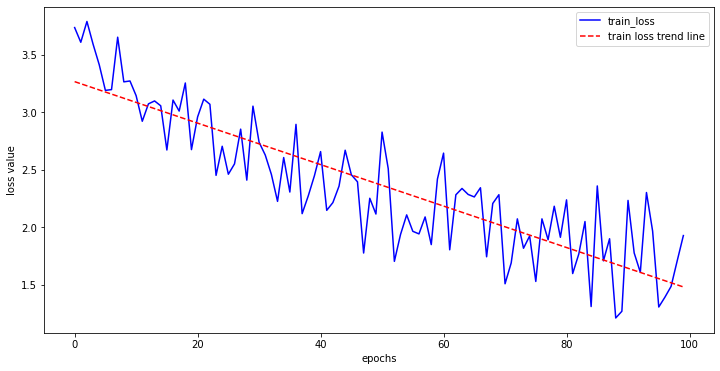

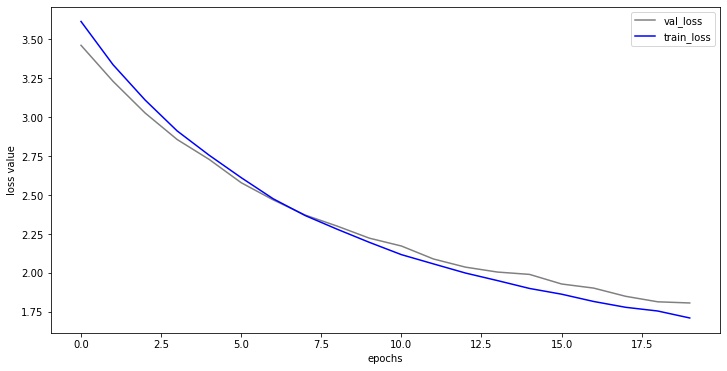

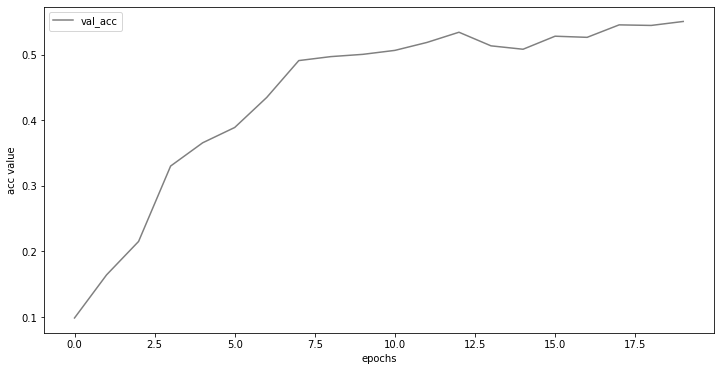

In [5]:

with open('/content/drive/MyDrive/saved/result.json') as json_file:
    data = json.load(json_file)

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(0, len(data['train_loss']), 1)
y = data['train_loss']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(y, color='blue', label='train_loss')
ax.plot(x,p(x),"r--", color='red', label='train loss trend line' )
ax.set_xlabel('epochs')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(0, 10, 0.1)
z = data['val_loss']
k = data['mean_train_loss']
ax.plot(z, color='grey', label='val_loss')
ax.plot(k, color='blue', label='train_loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss value')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
z = data['val_acc']
ax.plot(z, color='grey', label='val_acc')
ax.set_xlabel('epochs')
ax.set_ylabel('acc value')
ax.legend()
plt.show()